In [1]:
""" 

DESCRIPTION

1. Multiple linear regression between timing of glacier ice coverage and 1) snowfall and 2) air temperature in the 
"month prior to the mean date of ice coverage"

"""

# Import libraries
import glob
import os
import numpy as np
import xarray as xr
import netCDF4
import pandas as pd
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/'

In [19]:
# Read data
index_data = xr.open_dataset(path + 'masks/index_main.nc', engine='netcdf4')

# Define maximum snowline
snowline_file = netCDF4.Dataset(path + 'masks/monthly_bare_ice_2012.nc')
snowline = snowline_file.variables['bare_ice'][1, :, :].filled(np.nan)
max_snowline = (snowline > 0.1)

# Define indices
index = list(zip(index_data['index_x'].values, index_data['index_y'].values))

# Define MERRA and albedo files
merra_snow_files = sorted(glob.glob(path + 'merra_snowfall_modern/*.nc'))
merra_temp_files = sorted(glob.glob(path + 'merra_t2m_modern/*.nc'))
exposure_files = sorted(glob.glob(path + 'modis_exposure_v2/*.nc'))

# Define regions
regions = np.arange(1, 9)

# Define number of years
years = np.arange(2001, 2022, 1)

# Read optimal DOY data
doy = pd.read_csv(path + 'optimal_doy.csv')

In [23]:
doy.iloc[:,region][5]

236

In [40]:
mean_exposure = []
mean_snowfall = []
mean_temp = []

for region in regions:
    
    # Define date range (month prior to mean date of glacier ice exposure)
    t_start = int(doy.iloc[:,region][6])
    s_start = int(doy.iloc[:,region][6])
    e_end = int(doy.iloc[:,region][5])
    
    region_exposure = []
    region_snowfall = []
    region_temp = []
    for i in range(len(years)):
        
        # Import data
        snow = xr.open_dataset(merra_snow_files[i])
        temp = xr.open_dataset(merra_temp_files[i])
        expo = xr.open_dataset(exposure_files[i])

        # Mask ablation zone
        abl_expo = expo['last_60'].values[max_snowline].astype(float)
        abl_expo[abl_expo == 0] = np.nan

        region_mask = index_data['region'].values == region
        region_snowfall.append(np.nanmean(np.mean(snow['snowfall'][s_start:e_end, :], axis=0)[region_mask]) * 86400 * 365 / 1000)
        region_temp.append(np.nanmean(np.mean(temp['t2m'][t_start:e_end, :], axis=0)[region_mask]))
        region_exposure.append(np.nanmedian(abl_expo[region_mask]))
        
    mean_exposure.append(region_exposure)
    mean_snowfall.append(region_snowfall)
    mean_temp.append(region_temp)

In [41]:
df_snowfall = pd.DataFrame(np.array(mean_snowfall).T, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
df_temp = pd.DataFrame(np.array(mean_temp).T, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
df_exposure = pd.DataFrame(np.array(mean_exposure).T, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

df_temp['year'] = years
df_snowfall['year'] = years
df_exposure['year'] = years

In [42]:
df_exposure.mean()

N        228.761905
NE       235.142857
E        250.523810
SE       258.238095
S        252.857143
SW       241.142857
W        242.142857
NW       240.857143
year    2011.000000
dtype: float64

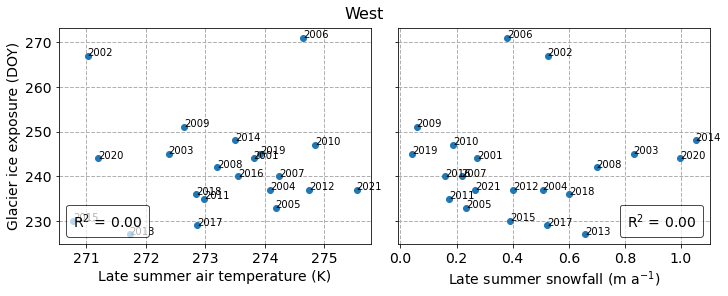

In [50]:
reg = 'W'
reg_name = 'West'

s1, i1, r1, p1, e1 = stats.linregress(df_temp[reg],df_exposure[reg])
s2, i2, r2, p2, e2 = stats.linregress(df_snowfall[reg],df_exposure[reg])

df = pd.concat([df_snowfall[reg], df_temp[reg]], axis=1)
df.columns = ['snow','temp']

X = df[['snow', 'temp']]
y = df_exposure[reg]

# Compute adjusted R2
r2_adj1 = 1 - (1 - r1**2) * (df_temp[reg].shape[0] - 1) / (df_exposure[reg].shape[0] - df[['temp']].shape[1] - 1)
r2_adj2 = 1 - (1 - r2**2) * (df_temp[reg].shape[0] - 1) / (df_exposure[reg].shape[0] - df[['temp']].shape[1] - 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True, layout='constrained')
fig.suptitle(reg_name, fontsize=16)
ax1.scatter(df_temp[reg], df_exposure[reg], zorder=2)
ax1.set_xlabel('Late summer air temperature (K)', fontsize=14)
ax1.set_ylabel('Glacier ice exposure (DOY)', fontsize=14)

textstr = f'R$^2$ = {r1**2:.2f}'
text_box = AnchoredText(textstr, frameon=True, loc=3, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax1.add_artist(text_box)
for i, label in enumerate(list(df_temp['year'])):
    ax1.annotate(label, (df_temp[reg][i], df_exposure[reg][i]))

ax2.scatter(df_snowfall[reg], df_exposure[reg], zorder=2)
ax2.set_xlabel('Late summer snowfall (m a$^{-1}$)', fontsize=14)

textstr = f'R$^2$ = {r2**2:.2f}'
text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax2.add_artist(text_box)
for i, label in enumerate(list(df_temp['year'])):
    ax2.annotate(label, (df_snowfall[reg][i], df_exposure[reg][i]))

for ax in [ax1, ax2]:
    ax.grid(ls='dashed', lw=1, zorder=1)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig('/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/figures/fall_' + reg_name + '.png', dpi=200)

In [114]:
# Perform multiple linear regression
df = pd.concat([df_snowfall[reg], df_temp[reg]], axis=1)
df.columns = ['snow','temp']

X = df[['snow', 'temp']]
y = df_albedo[reg]

model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [115]:
# Compute adjusted R2
yhat = model.predict(X)
r2 = r2_score(y, yhat)
adj_r2 = 1 - (1 - r2) * (y.shape[0] - 1) / (y.shape[0] - df[['snow', 'temp']].shape[1] - 1)

In [116]:
# Compare coefficients scaled by standard deviation
# https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
print(model.coef_ * X.std())

snow    1.643437
temp   -2.965548
dtype: float64


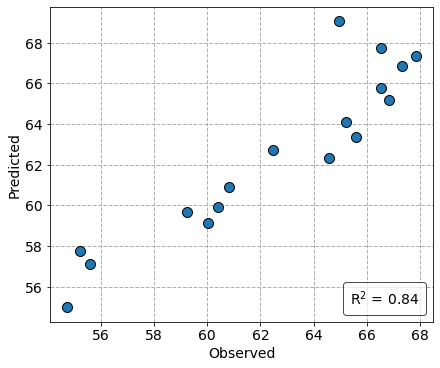

In [117]:
fig, ax1 = plt.subplots(figsize=(6, 5), layout='constrained')

ax1.scatter(y, yhat, s=100, edgecolor='k', zorder=2)
ax1.set_xlabel('Observed', fontsize=14)
ax1.set_ylabel('Predicted', fontsize=14)

textstr = f'R$^2$ = {adj_r2:.2f}'
text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax1.add_artist(text_box)

ax1.grid(ls='dashed', lw=1, zorder=1)
ax1.tick_params(axis='both', which='major', labelsize=14)

In [118]:
# Repeat using statsmodels
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()

def results_summary_to_df(results):

    pvals = results.pvalues
    coeff = results.params
    r2 = results.rsquared_adj

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "r2_adj_both":r2,
                               "r2_temp":r2_adj1,
                               "r2_snow":r2_adj2,
                                })

    results_df = results_df[["coeff", "pvals", "r2_adj_both", "r2_temp", "r2_snow"]]
    return results_df

In [119]:
results_summary_to_df(results)

,coeff,pvals,r2_adj_both,r2_temp,r2_snow
const,962.013810,0.000037,0.84218,0.733936,0.489722
snow,11.626525,0.007852,0.84218,0.733936,0.489722
temp,-3.303787,0.000066,0.84218,0.733936,0.489722


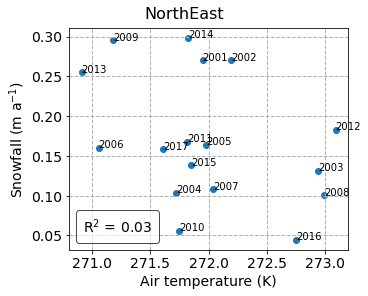

In [128]:
reg = 'NE'
reg_name = 'NorthEast'

s1, i1, r1, p1, e1 = stats.linregress(df_temp[reg], df_snowfall[reg])

# Compute adjusted R2
r2_adj1 = 1 - (1 - r1**2) * (df_temp[reg].shape[0] - 1) / (df_snowfall[reg].shape[0] - 2 - 1)
r2_adj2 = 1 - (1 - r2**2) * (df_temp[reg].shape[0] - 1) / (df_snowfall[reg].shape[0] - 2 - 1)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 4), layout='constrained')
fig.suptitle(reg_name, fontsize=16)
ax1.scatter(df_temp[reg], df_snowfall[reg])
ax1.set_xlabel('Air temperature (K)', fontsize=14)
ax1.set_ylabel('Snowfall (m a$^{-1}$)', fontsize=14)

textstr = f'R$^2$ = {r2_adj1:.2f}'
text_box = AnchoredText(textstr, frameon=True, loc=3, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax1.add_artist(text_box)
for i, label in enumerate(list(df_temp['year'])):
    ax1.annotate(label, (df_temp[reg][i], df_snowfall[reg][i]))

ax1.grid(ls='dashed', lw=1)
ax1.tick_params(axis='both', which='major', labelsize=14)